# Importing the required libraries

In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
from typing import Optional, Callable, Tuple
import PIL
import csv
import pathlib
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torchvision.transforms.v2 import ToTensor,Resize,Compose,ColorJitter,RandomRotation,AugMix,RandomCrop,GaussianBlur,RandomEqualize,RandomHorizontalFlip,RandomVerticalFlip
import tqdm
from sklearn.metrics import accuracy_score
import torch
import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import Inception_V3_Weights



# selecting our gpu 

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Make a custom class for the gtsrb dataset

In [15]:
class GTSRB(Dataset):
    def __init__(self, root: str, split: str, transform: Optional[Callable] = None):
        self.base_folder = pathlib.Path(root)
        self.csv_file = self.base_folder / ('Train.csv' if split == 'train' else 'Test.csv')

        with open('/' + str(self.csv_file)) as csvfile:
            samples = [('/' + str(self.base_folder / row['Path']), int(row['ClassId']))
                       for row in csv.DictReader(csvfile, delimiter=',', skipinitialspace=True)]

        self.samples = samples
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple:
        path, classId = self.samples[index]
        sample = PIL.Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, classId
     

# Augmenting our data by applying some transformations (brightness, contrast, vertical-horizontal flip, Rotations, Blur...)

In [16]:
train_transforms = Compose([
    ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
    RandomEqualize(0.4),
    AugMix(),
    RandomHorizontalFlip(0.3),
    RandomVerticalFlip(0.3),
    GaussianBlur((3,3)),
    RandomRotation(30),

    Resize([50,50]),
    ToTensor(),
    
])

validation_transforms = Compose([
    Resize([50, 50]),
    ToTensor(),
])

# splitting our dataset into train and validation 

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
def train_test_split(dataset, train_size):
    train_size = int(train_size * len(dataset))
    test_size = int(len(dataset) - train_size)
    return random_split(dataset, [train_size, test_size])

In [18]:
dataset = GTSRB(root='/content/drive/MyDrive/Traffic_Sign_Data', split="train")
train_set, validation_set = train_test_split(dataset, train_size=0.8)
print(f'Training size: {len(train_set)}, Validation size: {len(validation_set)}')

Training size: 31367, Validation size: 7842


# visualizing the data

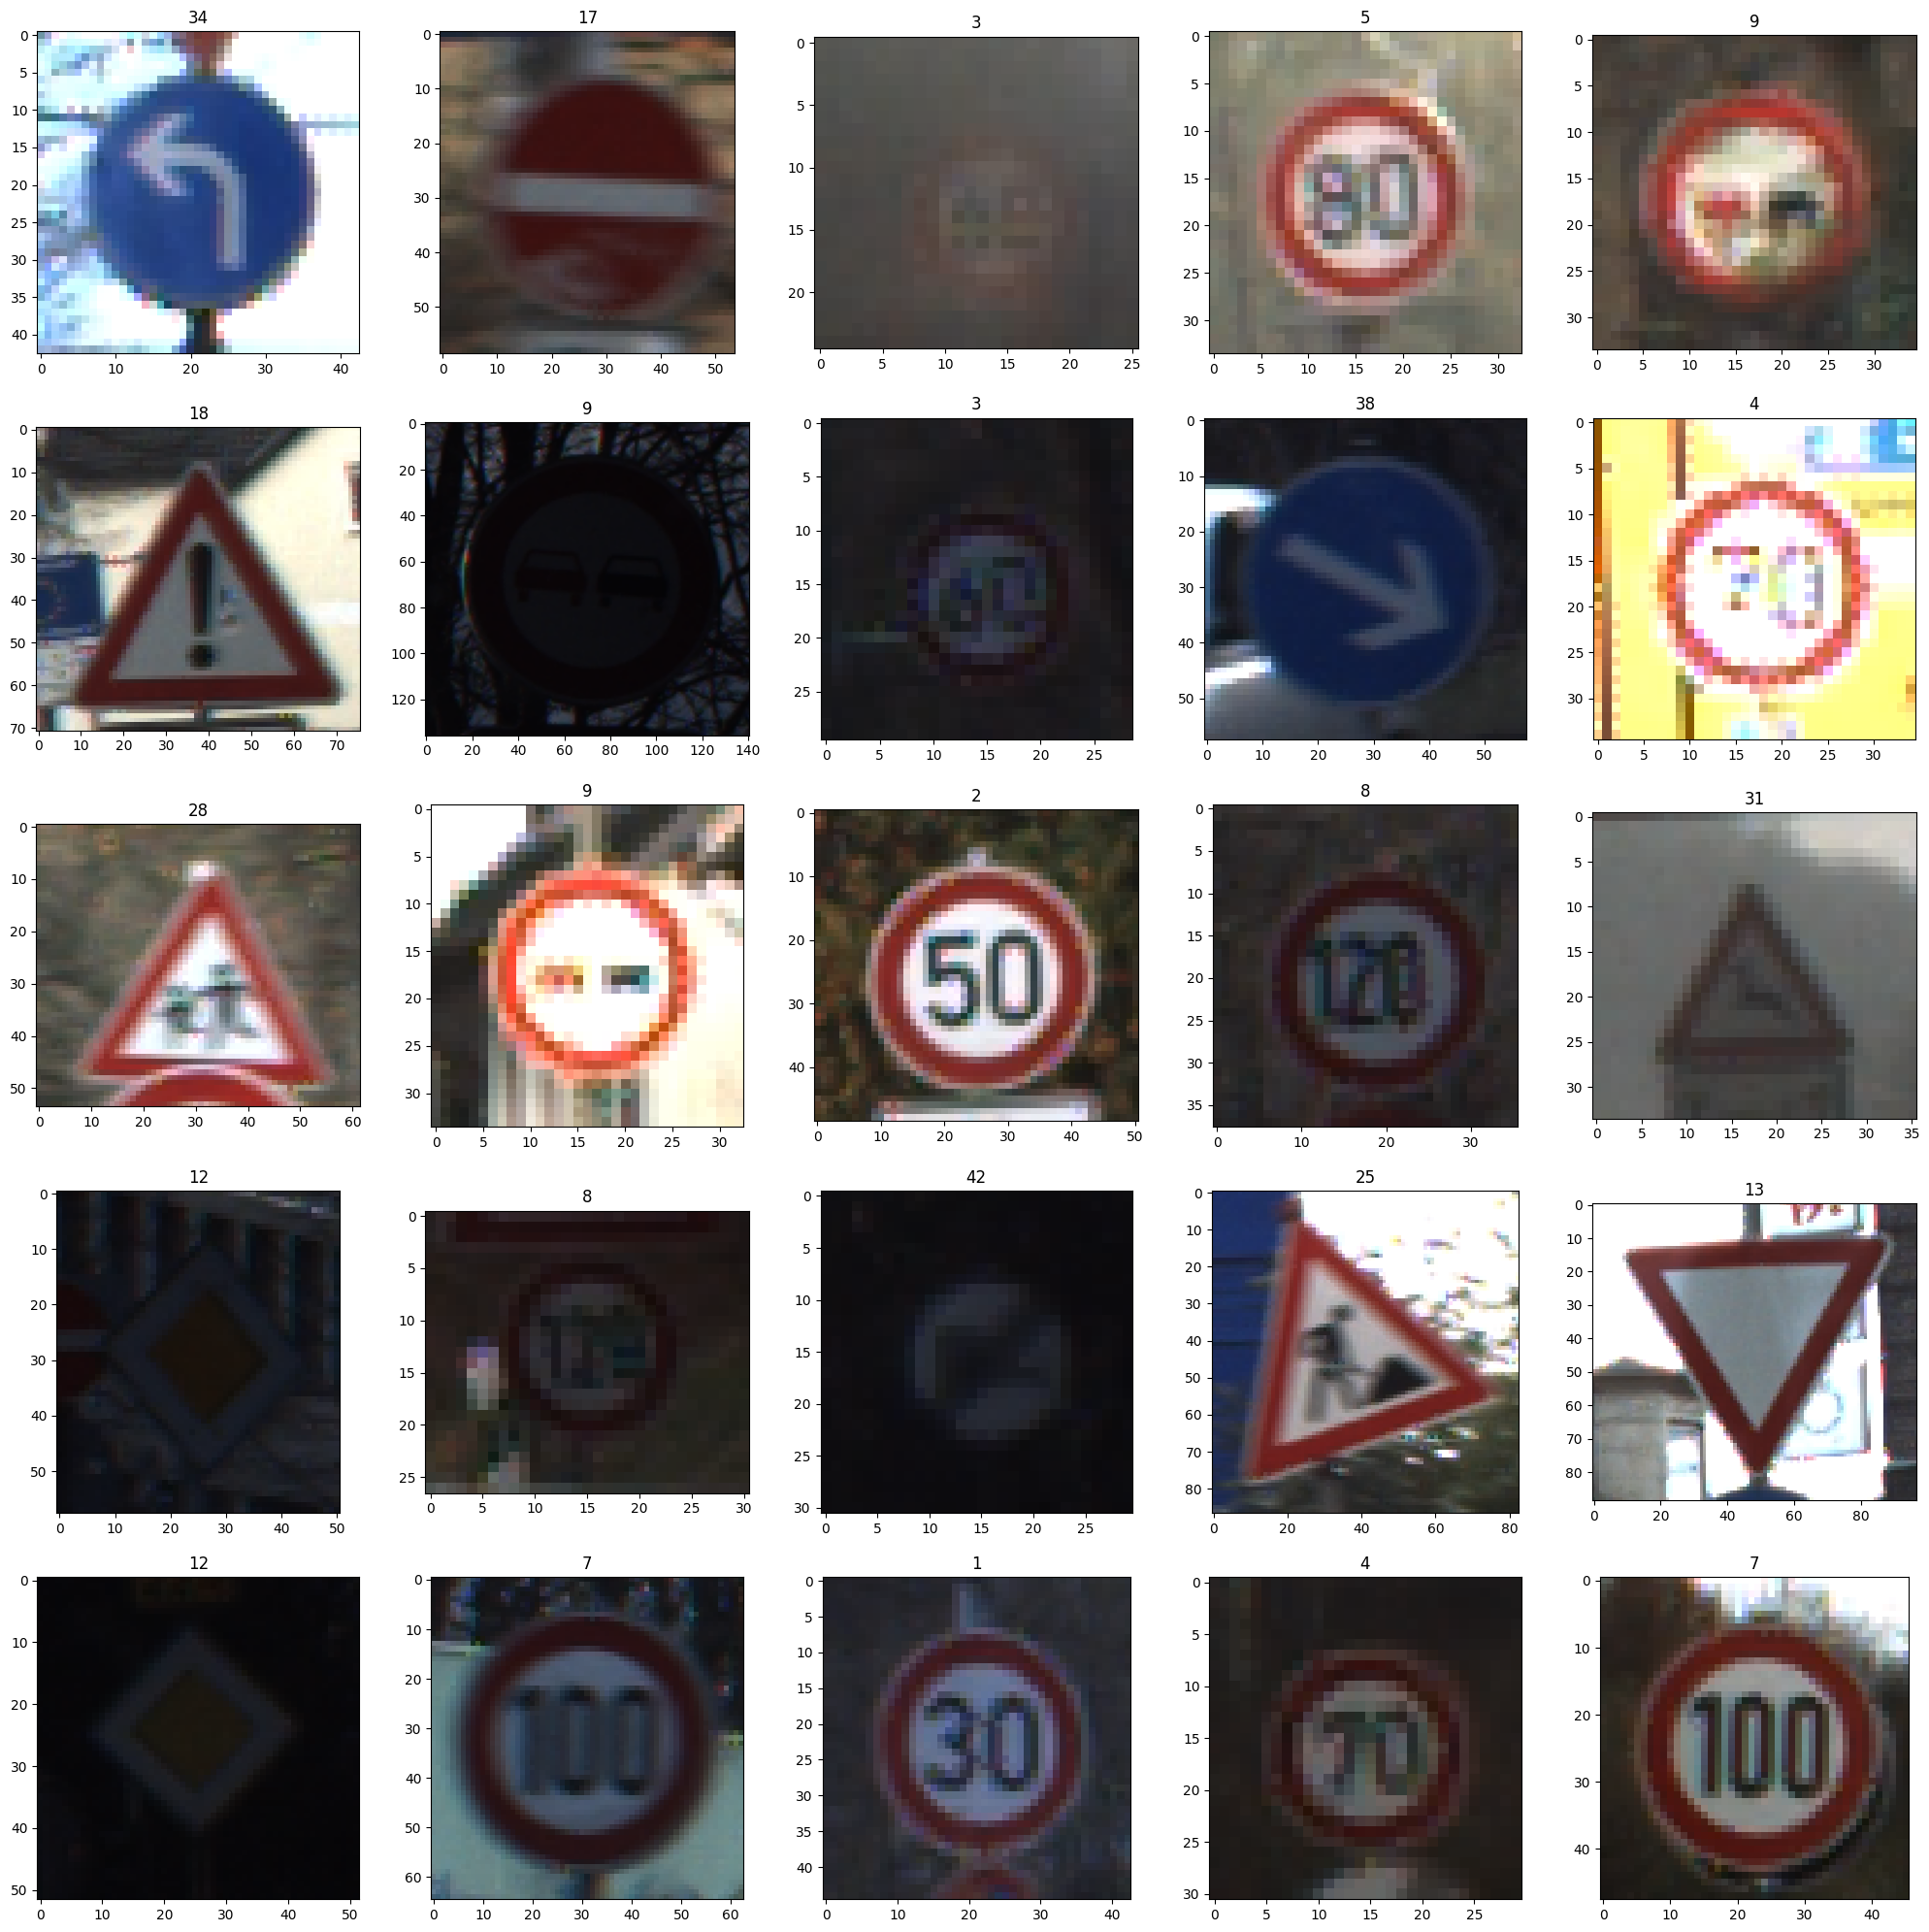

In [19]:
plt.figure(figsize=(25,25))
for i in range(1,26):
    input,label = train_set[i]
    plt.subplot(5,5,i)
    plt.title(label)
    plt.imshow(input)

# Applying the transformations

In [20]:
train_set.dataset.transform = train_transforms
validation_set.dataset.transform = validation_transforms

# Loading the data

In [21]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=BATCH_SIZE)

# Building a convolutional neural network model

In [22]:
class GTSRB_MODEL(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(GTSRB_MODEL, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def training_metrics(self,positives,data_size,loss):
        acc = positives/data_size
        return loss,acc
    
    def validation_metrics(self,validation_data,loss_function):
       data_size = len(validation_data)
       correct_predictions = 0
       total_samples = 0
       val_loss = 0

       model = self.eval()
       with torch.no_grad() : 
        for step,(input,label) in enumerate(validation_data):
            input,label = input.to(device),label.to(device)
            prediction = model.forward(input)
            loss = loss_function(prediction,label)
            val_loss = loss.item()
            _,predicted = torch.max(prediction,1)
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

       val_acc = correct_predictions/total_samples

       return val_loss,val_acc

    def history(self):
        return self.metrics

    def compile(self,train_data,validation_data,epochs,loss_function,optimizer,learning_rate_scheduler):
        val_acc_list = []
        val_loss_list = []

        train_acc_list = []
        train_loss_list = []

        learning_rate_list = []

        print('training started ...')
        STEPS = len(train_data)
        for epoch in range(epochs):
            lr = optimizer.param_groups[0]["lr"]
            learning_rate_list.append(lr)
            correct_predictions = 0
            total_examples = 0
            loss = 0
            with tqdm.trange(STEPS) as progress:

                for step,(input,label) in enumerate(train_loader):

                    input,label = input.to(device),label.to(device)
                    prediction = self.forward(input)

                    _, predicted = torch.max(prediction, 1)
                    correct_predictions += (predicted == label).sum().item()
                    total_examples += label.size(0)
                    l = loss_function(prediction,label)
                    loss = l.item()
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    progress.colour = 'green'
                    progress.desc = f'Epoch [{epoch}/{EPOCHS}], Step [{step}/{STEPS}], Learning Rate [{lr}], Loss [{"{:.4f}".format(l)}], Accuracy [{"{:.4f}".format(correct_predictions/total_examples)}]'
                    progress.update(1)

            training_loss,training_acc = self.training_metrics(correct_predictions,total_examples,loss)
            train_acc_list.append(training_acc)
            train_loss_list.append(training_loss)

            val_loss, val_acc = self.validation_metrics(validation_data,loss_function)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
            
            print(f'val_accuracy [{val_acc}], val_loss [{val_loss}]')

            
            learning_rate_scheduler.step()
        
        metrics_dict = {
                'train_acc':train_acc_list,
                'train_loss':train_loss_list,
                'val_acc':val_acc_list,
                'val_loss':val_loss_list,
                'learning_rate':optimizer.param_groups[0]["lr"]
            }
        self.metrics = metrics_dict
        print('training complete !')    

        

# Training our model

In [23]:
EPOCHS = 20
LEARNING_RATE = 0.0008
INPUT_CHANNELS = 3
OUTPUT_DIM = 43
model = GTSRB_MODEL(INPUT_CHANNELS, OUTPUT_DIM).to(device)

optimizer = Adam(params=model.parameters(), lr=LEARNING_RATE)
lr_s = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=10)
loss = nn.CrossEntropyLoss()


In [24]:
model.compile(train_data=train_loader,validation_data=validation_loader,epochs=EPOCHS,loss_function=loss,optimizer=optimizer,learning_rate_scheduler=lr_s)

training started ...


Epoch [0/20], Step [490/491], Learning Rate [0.0008], Loss [0.8629], Accuracy [0.6426]: 100%|██████████| 491/491 [04:20<00:00,  1.88it/s]


val_accuracy [0.9176230553430247], val_loss [0.20311512053012848]


Epoch [1/20], Step [490/491], Learning Rate [0.00076], Loss [0.0323], Accuracy [0.9449]: 100%|██████████| 491/491 [00:59<00:00,  8.24it/s]


val_accuracy [0.961489415965315], val_loss [0.21240590512752533]


Epoch [2/20], Step [490/491], Learning Rate [0.00072], Loss [0.0261], Accuracy [0.9735]: 100%|██████████| 491/491 [01:00<00:00,  8.07it/s]


val_accuracy [0.9683754144350931], val_loss [0.2406708002090454]


Epoch [3/20], Step [490/491], Learning Rate [0.00068], Loss [0.0231], Accuracy [0.9835]: 100%|██████████| 491/491 [00:59<00:00,  8.20it/s]


val_accuracy [0.9704157102779903], val_loss [0.0605032742023468]


Epoch [4/20], Step [490/491], Learning Rate [0.00064], Loss [0.0025], Accuracy [0.9884]: 100%|██████████| 491/491 [00:59<00:00,  8.21it/s]


val_accuracy [0.9835501147666411], val_loss [0.09387665241956711]


Epoch [5/20], Step [490/491], Learning Rate [0.0006000000000000001], Loss [0.0028], Accuracy [0.9913]: 100%|██████████| 491/491 [00:59<00:00,  8.28it/s]


val_accuracy [0.9818923743942872], val_loss [0.17224307358264923]


Epoch [6/20], Step [490/491], Learning Rate [0.0005600000000000001], Loss [0.0015], Accuracy [0.9948]: 100%|██████████| 491/491 [01:02<00:00,  7.91it/s]


val_accuracy [0.9845702626880898], val_loss [0.046455997973680496]


Epoch [7/20], Step [490/491], Learning Rate [0.0005200000000000001], Loss [0.0089], Accuracy [0.9962]: 100%|██████████| 491/491 [00:58<00:00,  8.37it/s]


val_accuracy [0.9881407804131599], val_loss [0.10195720940828323]


Epoch [8/20], Step [490/491], Learning Rate [0.00048000000000000007], Loss [0.0030], Accuracy [0.9958]: 100%|██████████| 491/491 [01:00<00:00,  8.15it/s]


val_accuracy [0.988268298903341], val_loss [0.067294642329216]


Epoch [9/20], Step [490/491], Learning Rate [0.00044000000000000007], Loss [0.0000], Accuracy [0.9981]: 100%|██████████| 491/491 [00:58<00:00,  8.34it/s]


val_accuracy [0.9875031879622546], val_loss [0.07934574037790298]


Epoch [10/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [0.9994]: 100%|██████████| 491/491 [01:03<00:00,  7.77it/s]


val_accuracy [0.9906911502167814], val_loss [0.09303810447454453]


Epoch [11/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0018], Accuracy [0.9975]: 100%|██████████| 491/491 [01:01<00:00,  7.93it/s]


val_accuracy [0.9868655955113491], val_loss [0.21619877219200134]


Epoch [12/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [0.9975]: 100%|██████████| 491/491 [01:00<00:00,  8.12it/s]


val_accuracy [0.9903085947462382], val_loss [0.1374741792678833]


Epoch [13/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [0.9984]: 100%|██████████| 491/491 [00:59<00:00,  8.22it/s]


val_accuracy [0.9831675592960979], val_loss [0.11446843296289444]


Epoch [14/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.1178], Accuracy [0.9974]: 100%|██████████| 491/491 [00:59<00:00,  8.26it/s]


val_accuracy [0.9834225962764601], val_loss [0.16436068713665009]


Epoch [15/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0792], Accuracy [0.9981]: 100%|██████████| 491/491 [00:59<00:00,  8.30it/s]


val_accuracy [0.9868655955113491], val_loss [0.03749725595116615]


Epoch [16/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0001], Accuracy [0.9974]: 100%|██████████| 491/491 [00:58<00:00,  8.35it/s]


val_accuracy [0.9868655955113491], val_loss [0.0896843895316124]


Epoch [17/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0017], Accuracy [0.9989]: 100%|██████████| 491/491 [00:59<00:00,  8.25it/s]


val_accuracy [0.9909461871971436], val_loss [0.09478016197681427]


Epoch [18/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0015], Accuracy [0.9999]: 100%|██████████| 491/491 [00:59<00:00,  8.29it/s]


val_accuracy [0.9922213720989543], val_loss [0.031539980322122574]


Epoch [19/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0013], Accuracy [0.9999]: 100%|██████████| 491/491 [00:59<00:00,  8.23it/s]


val_accuracy [0.9923488905891354], val_loss [0.038523074239492416]

training complete !


In [25]:
transforms = Compose([
    Resize([50,50]),
    ToTensor(),
    
])

testdata = GTSRB(root='/content/drive/MyDrive/Traffic_Sign_Data',split='test',transform=transforms)
print('testing size :',len(testdata))
test_dataloader = DataLoader(testdata)




testing size : 12630


In [26]:
from sklearn.metrics import accuracy_score

y_pred = []
y_true = []
model = model.eval().to(device)
with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
  
  with torch.no_grad() : 
    for id,(input,label) in enumerate(iter(test_dataloader)):
        input,label = input.to(device),label.to(device)
        y_true.append(label.item())
        prediction = model.forward(input)
        _,prediction = torch.max(prediction,1)
        y_pred.append(prediction.item())
        
        progress.desc = f'Test Accuracy : {accuracy_score(y_true,y_pred)} '
        progress.update(1)
        
       

Test Accuracy : 0.9304038004750593 : 100%|██████████| 12630/12630 [03:12<00:00, 65.58it/s]


## ResNetGTSRB

In [28]:
# Model parameters
OUTPUT_DIM = 43  # Set the number of output classes
EPOCHS = 10  # Set the number of epochs

# Initialize the model
class ResNetGTSRB(nn.Module):
    def __init__(self, output_dim):
        super(ResNetGTSRB, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, output_dim)

    def forward(self, x):
        return self.resnet(x)

# Initialize the ResNet model
model3 = ResNetGTSRB(OUTPUT_DIM).to(device)

# Loss function, optimizer, and scheduler
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(params=model3.parameters(), lr=0.0008)  # Adjust the learning rate as needed
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
EPOCHS = 20
# Training loop
for epoch in range(EPOCHS):
    model3.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model3(inputs)
        loss = loss_function(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

# Validation loop (similar to your existing validation loop)
model3.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model3(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
        

# Save the model
torch.save(model3.state_dict(), 'resnet_model.pth')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth

100%|██████████| 97.8M/97.8M [00:00<00:00, 245MB/s] 


Epoch [1/20], Loss: 0.0262

Epoch [2/20], Loss: 0.0043

Epoch [3/20], Loss: 0.0012

Epoch [4/20], Loss: 0.2180

Epoch [5/20], Loss: 0.8990

Epoch [6/20], Loss: 0.0559

Epoch [7/20], Loss: 0.3456

Epoch [8/20], Loss: 0.0019

Epoch [9/20], Loss: 0.1169

Epoch [10/20], Loss: 0.0090

Epoch [11/20], Loss: 0.1507

Epoch [12/20], Loss: 0.1418

Epoch [13/20], Loss: 0.0242

Epoch [14/20], Loss: 0.0035

Epoch [15/20], Loss: 0.0053

Epoch [16/20], Loss: 1.4556

Epoch [17/20], Loss: 0.0780

Epoch [18/20], Loss: 0.0546

Epoch [19/20], Loss: 0.1251

Epoch [20/20], Loss: 0.0366

Test Accuracy: 0.9550


## VGGGTSRB

In [30]:
# Initialize the model
class VGGGTSRB(nn.Module):
    def __init__(self, output_dim):
        super(VGGGTSRB, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        num_features = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Linear(num_features, output_dim)

    def forward(self, x):
        return self.vgg(x)

# Initialize the VGG model
model4 = VGGGTSRB(output_dim=43).to(device)

# Loss function, optimizer, and scheduler
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(params=model4.parameters(), lr=0.0008)  # Adjust the learning rate as needed
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Training loop
for epoch in range(EPOCHS):
    model4.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model4(inputs)
        loss = loss_function(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')


model4.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model4(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Save the model
torch.save(model4.state_dict(), 'vgg_model.pth')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/20], Loss: 4.0939

Epoch [2/20], Loss: 3.3119

Epoch [3/20], Loss: 3.6780

Epoch [4/20], Loss: 3.5379

Epoch [5/20], Loss: 3.6138

Epoch [6/20], Loss: 3.2845

Epoch [7/20], Loss: 3.3517

Epoch [8/20], Loss: 3.1553

Epoch [9/20], Loss: 3.3262

Epoch [10/20], Loss: 3.5436

Epoch [11/20], Loss: 3.3015

Epoch [12/20], Loss: 3.5500

Epoch [13/20], Loss: 3.5142

Epoch [14/20], Loss: 3.5952

Epoch [15/20], Loss: 3.6187

Epoch [16/20], Loss: 3.4507

Epoch [17/20], Loss: 3.2658

Epoch [18/20], Loss: 4.1649

Epoch [19/20], Loss: 3.1965

Epoch [20/20], Loss: 3.5193

Test Accuracy: 0.0594


## DenseNetGTSRB

In [31]:
# Initialize the model
class DenseNetGTSRB(nn.Module):
    def __init__(self, output_dim):
        super(DenseNetGTSRB, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, output_dim)

    def forward(self, x):
        return self.densenet(x)

# Initialize the DenseNet model
model5 = DenseNetGTSRB(output_dim=43).to(device)

# Loss function, optimizer, and scheduler
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(params=model5.parameters(), lr=0.0008)  # Adjust the learning rate as needed
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Training loop
for epoch in range(EPOCHS):
    model5.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model5(inputs)
        loss = loss_function(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

# Validation loop 
model5.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model5(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Save the model
torch.save(model5.state_dict(), 'densenet_model.pth')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth

100%|██████████| 30.8M/30.8M [00:00<00:00, 193MB/s]


Epoch [1/20], Loss: 0.3816

Epoch [2/20], Loss: 0.2074

Epoch [3/20], Loss: 0.1069

Epoch [4/20], Loss: 0.2236

Epoch [5/20], Loss: 0.0675

Epoch [6/20], Loss: 0.0197

Epoch [7/20], Loss: 0.3241

Epoch [8/20], Loss: 0.6690

Epoch [9/20], Loss: 0.2880

Epoch [10/20], Loss: 0.1133

Epoch [11/20], Loss: 0.0327

Epoch [12/20], Loss: 0.0644

Epoch [13/20], Loss: 0.0254

Epoch [14/20], Loss: 0.2999

Epoch [15/20], Loss: 0.0255

Epoch [16/20], Loss: 0.0818

Epoch [17/20], Loss: 0.0113

Epoch [18/20], Loss: 0.1804

Epoch [19/20], Loss: 0.0205

Epoch [20/20], Loss: 0.0030

Test Accuracy: 0.9806


## MobileNetGTSRB

In [32]:
# Initialize the model
class MobileNetGTSRB(nn.Module):
    def __init__(self, output_dim):
        super(MobileNetGTSRB, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, output_dim)

    def forward(self, x):
        return self.mobilenet(x)

# Initialize the MobileNetV2 model
model6 = MobileNetGTSRB(output_dim=43).to(device)

# Loss function, optimizer, and scheduler
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(params=model6.parameters(), lr=0.0008)  # Adjust the learning rate as needed
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Training loop
for epoch in range(EPOCHS):
    model6.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model6(inputs)
        loss = loss_function(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

# Test loop 
model6.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model6(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Save the model
torch.save(model6.state_dict(), 'mobilenet_model.pth')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth

100%|██████████| 13.6M/13.6M [00:00<00:00, 121MB/s] 


Epoch [1/20], Loss: 0.4061

Epoch [2/20], Loss: 0.3024

Epoch [3/20], Loss: 0.5358

Epoch [4/20], Loss: 0.0284

Epoch [5/20], Loss: 0.2988

Epoch [6/20], Loss: 0.0387

Epoch [7/20], Loss: 0.5427

Epoch [8/20], Loss: 0.0497

Epoch [9/20], Loss: 1.6395

Epoch [10/20], Loss: 0.0307

Epoch [11/20], Loss: 0.6840

Epoch [12/20], Loss: 0.9161

Epoch [13/20], Loss: 0.0315

Epoch [14/20], Loss: 0.0231

Epoch [15/20], Loss: 0.9927

Epoch [16/20], Loss: 0.0461

Epoch [17/20], Loss: 0.0493

Epoch [18/20], Loss: 0.8036

Epoch [19/20], Loss: 0.0181

Epoch [20/20], Loss: 0.0127

Test Accuracy: 0.9743


## EfficientNetGTSRB

In [33]:
# Initialize the model
class EfficientNetGTSRB(nn.Module):
    def __init__(self, output_dim):
        super(EfficientNetGTSRB, self).__init__()
        self.efficientnet = models.resnet50(pretrained=True)
        num_features = self.efficientnet.fc.in_features
        self.efficientnet.fc = nn.Linear(num_features, output_dim)

    def forward(self, x):
        return self.efficientnet(x)

# Initialize the EfficientNet model
model2 = EfficientNetGTSRB(output_dim=43).to(device)

# Loss function, optimizer, and scheduler
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(params=model2.parameters(), lr=0.0008)  # Adjust the learning rate as needed
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Training loop
for epoch in range(EPOCHS):
    model2.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model2(inputs)
        loss = loss_function(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

# Validation loop 
model2.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Save the model
torch.save(model2.state_dict(), 'efficientnet_model.pth')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/20], Loss: 0.0120

Epoch [2/20], Loss: 0.2353

Epoch [3/20], Loss: 0.0016

Epoch [4/20], Loss: 0.0079

Epoch [5/20], Loss: 0.0168

Epoch [6/20], Loss: 0.4593

Epoch [7/20], Loss: 0.4949

Epoch [8/20], Loss: 0.1386

Epoch [9/20], Loss: 0.0661

Epoch [10/20], Loss: 0.1508

Epoch [11/20], Loss: 0.0552

Epoch [12/20], Loss: 0.0026

Epoch [13/20], Loss: 0.0108

Epoch [14/20], Loss: 0.0193

Epoch [15/20], Loss: 0.0386

Epoch [16/20], Loss: 1.3251

Epoch [17/20], Loss: 0.0233

Epoch [18/20], Loss: 0.0051

Epoch [19/20], Loss: 0.0096

Epoch [20/20], Loss: 0.0079

Test Accuracy: 0.9782


## InceptionGTSRB

In [34]:
class InceptionGTSRB(nn.Module):
    def __init__(self, output_dim):
        super(InceptionGTSRB, self).__init__()
        # Load pre-trained Inception v3 model with the updated weights parameter
        self.inception = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        # Adjust the classifier to match the number of classes
        num_features = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_features, output_dim)

    def forward(self, x):
        # Handle the aux_logits during training
        if self.training:
            x, aux = self.inception(x)
            return x
        else:
            return self.inception(x)

In [35]:
train_transforms = Compose([
#     ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
#     RandomEqualize(0.4),
#     AugMix(),
    RandomHorizontalFlip(0.3),
    RandomVerticalFlip(0.3),
    #GaussianBlur((3,3)),
    #RandomRotation(30),

    Resize([299, 299]),
    ToTensor(),
    
])
train_set.dataset.transform = train_transforms

train_loader = DataLoader(dataset=train_set,batch_size=BATCH_SIZE,shuffle=True)
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = InceptionGTSRB(OUTPUT_DIM).to(device)  # Ensure OUTPUT_DIM is set correctly

# Loss Function, Optimizer, and Learning Rate Scheduler
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)  # Use model2's parameters
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Training Loop
for epoch in range(EPOCHS):  # Make sure EPOCHS is defined
    model1.train()  # Set model2 to training mode
    for inputs, labels in train_loader:  # Ensure train_loader yields correctly sized images
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model1(inputs)
        loss = loss_function(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step()

    # Validation step (if necessary)
    model1.eval()  # Set model2 to evaluation mode
    

    # Print epoch results
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.

  warnings.warn(

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth

100%|██████████| 104M/104M [00:00<00:00, 236MB/s]  


Epoch [1/20], Loss: 0.4726

Epoch [2/20], Loss: 0.8210

Epoch [3/20], Loss: 0.0610

Epoch [4/20], Loss: 0.0458

Epoch [5/20], Loss: 0.0079

Epoch [6/20], Loss: 0.0179

Epoch [7/20], Loss: 0.4691

Epoch [8/20], Loss: 0.1400

Epoch [9/20], Loss: 0.0641

Epoch [10/20], Loss: 0.0717

Epoch [11/20], Loss: 0.1483

Epoch [12/20], Loss: 0.0166

Epoch [13/20], Loss: 0.0447

Epoch [14/20], Loss: 0.0590

Epoch [15/20], Loss: 0.0507

Epoch [16/20], Loss: 0.1463

Epoch [17/20], Loss: 0.0538

Epoch [18/20], Loss: 0.0166

Epoch [19/20], Loss: 0.0085

Epoch [20/20], Loss: 0.0123


In [36]:
transforms = Compose([
    Resize([299,299]),
    ToTensor(),
    
])

testdata = GTSRB(root='/content/drive/MyDrive/Traffic_Sign_Data',split='test',transform=transforms)
#print('testing size :',len(testdata))
test_dataloader = DataLoader(testdata)

model1.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_pred = []
y_true = []


with tqdm.tqdm(total=len(test_dataloader), colour='red') as progress:
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model1(inputs)
            _, predicted = torch.max(outputs, 1)

            y_pred.extend(predicted.cpu().tolist())
            y_true.extend(labels.cpu().tolist())
            
            # Update the progress bar description
            progress.set_description(f'Test Accuracy: {accuracy_score(y_true, y_pred):.4f}')
            progress.update(1)

# Final accuracy
final_accuracy = accuracy_score(y_true, y_pred)
print(f'Final Test Accuracy: {final_accuracy:.4f}')

Test Accuracy: 0.9790: 100%|██████████| 12630/12630 [05:26<00:00, 38.64it/s]

Final Test Accuracy: 0.9790
